### Libraries 📚⬇

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch

# Check CUDA availability
print(f"CUDA is available: {torch.cuda.is_available()}")
print(torch.version.cuda)
# Print CUDA device count
if torch.cuda.is_available():
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")

CUDA is available: False
None


In [4]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 20
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 500
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 512
# high res. image width
hr_width = 512
# number of image channels
channels = 3

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

In [5]:
%ls

 Volume in drive E is DATA
 Volume Serial Number is B867-DA30

 Directory of E:\[1]-Cascade learning-Unsafe behavior of cranes\Final data from UBDA-GVM\SrGan_module

07/08/2024  04:03 pm    <DIR>          .
05/08/2024  04:57 pm    <DIR>          ..
07/08/2024  03:59 pm    <DIR>          .ipynb_checkpoints
05/08/2024  05:00 pm    <DIR>          7-Detection data
05/08/2024  04:57 pm    <DIR>          images
05/08/2024  04:57 pm    <DIR>          saved_models
03/08/2024  01:40 am         4,832,472 srgan_code.ipynb
07/08/2024  04:03 pm            29,722 srgan_code_testing.ipynb
13/07/2024  01:40 pm         1,387,767 Srgan_data_generation.ipynb
08/07/2024  07:20 pm            26,025 srgan_model.ipynb
               4 File(s)      6,275,986 bytes
               6 Dir(s)  1,667,074,740,224 bytes free


In [6]:
import os


In [7]:
os.listdir('7-Detection data')

['low_Mobile_crane',
 'low_Mobile_crane-20240709T043315Z-001.zip',
 'low_Tower_crane',
 'low_Tower_crane-20240709T043317Z-001.zip',
 'Mobile_crane',
 'Mobile_crane-20240709T043321Z-001.zip',
 'Tower_crane',
 'Tower_crane-20240709T043326Z-001.zip']

### Settings ⚙️

### Define Dataset Class

In [8]:
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# # Normalization parameters
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, low_paths, high_paths):
        # Define transforms for images
        self.transform_lr = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()

        ])

        self.transform_hr = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

        self.low_paths = low_paths
        self.high_paths = high_paths

    def __getitem__(self, index):
        img_low = Image.open(self.low_paths[index % len(self.low_paths)])
        img_high = Image.open(self.high_paths[index % len(self.high_paths)])

        img_lr = self.transform_lr(img_low)
        img_hr = self.transform_hr(img_high)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return max(len(self.low_paths), len(self.high_paths))

In [9]:
len(os.listdir('7-Detection data/Mobile_crane')),len(os.listdir('7-Detection data/low_Mobile_crane'))

(2009, 2009)

In [10]:
len(os.listdir('7-Detection data/Tower_crane'))

2022

In [11]:
import glob

dataset_path = '7-Detection data'

low_paths1 = glob.glob(dataset_path + "/low_Mobile_crane/*.*")
low_paths2 = glob.glob(dataset_path + "/low_Tower_crane/*.*")
high_paths1 = glob.glob(dataset_path + "/Mobile_crane/*.*")
high_paths2 = glob.glob(dataset_path + "/Tower_crane/*.*")


low_paths = sorted(low_paths1 + low_paths2)
high_paths = sorted(high_paths1 + high_paths2)

print(len(low_paths))
print(len(high_paths))

4031
4031


In [12]:
# low_paths=low_paths[:1500]
# high_paths=high_paths[:1500]

In [13]:
train_low_paths, test_low_paths = train_test_split(low_paths, test_size=0.2, random_state=42)
train_high_paths, test_high_paths = train_test_split(high_paths, test_size=0.2, random_state=42)

batch_size = 8
n_cpu = 2

In [14]:
print(len(train_low_paths))
print(len(train_high_paths))

3224
3224


In [15]:
print(len(test_low_paths))
print(len(test_high_paths))

807
807


### Get Train/Test Dataloaders

In [16]:
train_dataset = ImageDataset(train_low_paths, train_high_paths)
test_dataset = ImageDataset(test_low_paths, test_high_paths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size), shuffle=False,num_workers=4)

### Define Model Classes

In [17]:
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         vgg19_model = vgg19(pretrained=True)
#         self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

#     def forward(self, img):
#         return self.feature_extractor(img)


# class ResidualBlock(nn.Module):
#     def __init__(self, in_features):
#         super(ResidualBlock, self).__init__()
#         self.conv_block = nn.Sequential(
#             nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(in_features, 0.8),
#             nn.PReLU(),
#             nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(in_features, 0.8),
#         )

#     def forward(self, x):
#         return x + self.conv_block(x)


# class GeneratorVGG(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
#         super(GeneratorVGG, self).__init__()

#         # First layer
#         self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

#         # Residual blocks
#         res_blocks = []
#         for _ in range(n_residual_blocks):
#             res_blocks.append(ResidualBlock(64))
#         self.res_blocks = nn.Sequential(*res_blocks)

#         # Second conv layer post residual blocks
#         self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

#         # Upsampling layers
#         upsampling = []
#         for out_features in range(2):
#             upsampling += [
#                 # nn.Upsample(scale_factor=2),
#                 nn.Conv2d(64, 256, 3, 1, 1),
#                 nn.BatchNorm2d(256),
#                 nn.PixelShuffle(upscale_factor=2),
#                 nn.PReLU(),
#             ]
#         self.upsampling = nn.Sequential(*upsampling)

#         # Final output layer
#         self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Sigmoid())

#     def forward(self, x):
#         out1 = self.conv1(x)
#         out = self.res_blocks(out1)
#         out2 = self.conv2(out)
#         out = torch.add(out1, out2)
#         out = self.upsampling(out)
#         out = self.conv3(out)
#         # Clamp the output to [0, 1] range
#         out = torch.clamp(out, min=0.0, max=1.0)
#         return out


# class Discriminator(nn.Module):
#     def __init__(self, input_shape):
#         super(Discriminator, self).__init__()

#         self.input_shape = input_shape
#         in_channels, in_height, in_width = self.input_shape
#         patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
#         self.output_shape = (1, patch_h, patch_w)

#         def discriminator_block(in_filters, out_filters, first_block=False):
#             layers = []
#             layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
#             if not first_block:
#                 layers.append(nn.BatchNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
#             layers.append(nn.BatchNorm2d(out_filters))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         layers = []
#         in_filters = in_channels
#         for i, out_filters in enumerate([64, 128, 256, 512]):
#             layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
#             in_filters = out_filters

#         layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

#         self.model = nn.Sequential(*layers)

#     def forward(self, img):
#         return self.model(img)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorVGG(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorVGG, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64))

        # Upsampling layers
        upsampling = []
        for out_features in range(3):
            upsampling += [
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Sigmoid())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        # Clamp the output to [0, 1] range
        out = torch.clamp(out, min=0.0, max=1.0)
        return out

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [19]:
# Initialize generator and discriminator
generator = GeneratorVGG()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

### Train Super Resolution GAN (SRGAN)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

In [21]:
ssss

NameError: name 'ssss' is not defined

In [23]:
ls

 Volume in drive E is DATA
 Volume Serial Number is B867-DA30

 Directory of E:\[1]-Cascade learning-Unsafe behavior of cranes\Final data from UBDA-GVM\SrGan_module

07/08/2024  04:03 pm    <DIR>          .
05/08/2024  04:57 pm    <DIR>          ..
07/08/2024  03:59 pm    <DIR>          .ipynb_checkpoints
05/08/2024  05:00 pm    <DIR>          7-Detection data
05/08/2024  04:57 pm    <DIR>          images
05/08/2024  04:57 pm    <DIR>          saved_models
03/08/2024  01:40 am         4,832,472 srgan_code.ipynb
07/08/2024  04:03 pm            29,722 srgan_code_testing.ipynb
13/07/2024  01:40 pm         1,387,767 Srgan_data_generation.ipynb
08/07/2024  07:20 pm            26,025 srgan_model.ipynb
               4 File(s)      6,275,986 bytes
               6 Dir(s)  1,667,074,740,224 bytes free


In [ ]:
# import torch
# from torch.autograd import Variable
# from torchvision.utils import save_image
# import matplotlib.pyplot as plt


# generator = GeneratorVGG()
# generator.load_state_dict(torch.load('saved_models/generator.pth',map_location=torch.device('cpu')))
# generator.eval()



# fig, axs = plt.subplots(4, 2, figsize=(10, 20))

# for idx in range(4):
#     imgs = next(iter(test_dataloader))

#     imgs_lr = Variable(imgs["lr"].type(torch.FloatTensor))

#     with torch.no_grad():
#         gen_hr = generator(imgs_lr)

#     original_hr = imgs["hr"][0].permute(1, 2, 0).numpy()
#     generated_hr = gen_hr[0].cpu().permute(1, 2, 0).numpy()
#     print("hello")

#     # Plot original HR image
#     axs[idx, 0].imshow(original_hr)
#     axs[idx, 0].set_title('Original HR')
#     axs[idx, 0].axis('off')

#     # Plot generated HR image
#     axs[idx, 1].imshow(generated_hr)
#     axs[idx, 1].set_title('Generated HR')
#     axs[idx, 1].axis('off')

# plt.tight_layout()
# plt.show()

In [28]:
import os
img_path=None
for folder in os.listdir("7-Detection data"):
    new_folder=os.path.join("7-Detection data",folder)
    if folder=="low_Mobile_crane" or folder=="low_Tower_crane":
        for img in os.listdir(new_folder):
            img_path=os.path.join(new_folder,img)
            print(img_path)
            break
    else:
        continue
    break

7-Detection data\low_Mobile_crane\A-MC (1).png


In [32]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformations
transform_lr = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust size to match your model input
    transforms.ToTensor()
])

# Load the generator model
generator = GeneratorVGG()
generator.load_state_dict(torch.load('saved_models/generator.pth', map_location=torch.device('cpu')))
# generator.eval()



<All keys matched successfully>

7-Detection data\low_Mobile_crane\A-MC (1).png


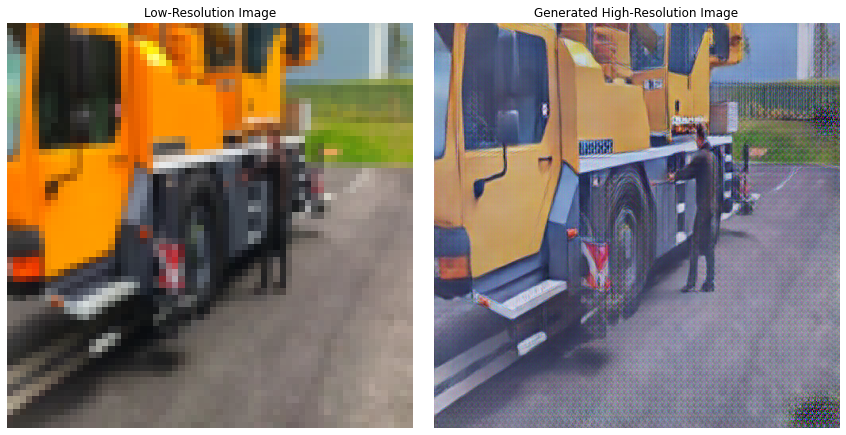

In [34]:
def predict_and_display(image_path):
    print(image_path)
    img_low = Image.open(image_path).convert('RGB')
    img_lr = transform_lr(img_low).unsqueeze(0)  # Add batch dimension

    # Generate the high-resolution image
    with torch.no_grad():
        gen_hr = generator(img_lr)

    # Convert images to numpy for visualization
    img_lr_np = img_lr.squeeze().permute(1, 2, 0).numpy()
    gen_hr_np = gen_hr.squeeze().cpu().permute(1, 2, 0).numpy()
    
    # Normalize the images to [0, 1] range for display
    img_lr_np = (img_lr_np - img_lr_np.min()) / (img_lr_np.max() - img_lr_np.min())
    gen_hr_np = (gen_hr_np - gen_hr_np.min()) / (gen_hr_np.max() - gen_hr_np.min())

    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(img_lr_np)
    axs[0].set_title('Low-Resolution Image')
    axs[0].axis('off')

    axs[1].imshow(gen_hr_np)
    axs[1].set_title('Generated High-Resolution Image')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

predict_and_display(img_path)